# Part 4 - Integrate Multiple Sources


In [6]:
dwh_basedir = "file:///srv/jupyter/nyc-dwh"
structured_basedir = dwh_basedir + "/structured"
refined_basedir = dwh_basedir + "/refined"
integrated_basedir = dwh_basedir + "/integrated"

# 0 Setup Environment

Before we begin, we create a local Spark session

## 0.1 Spark Session

In [7]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

In [8]:
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory","64G") \
    .getOrCreate()
spark.version

'2.4.3'

## 0.2 Matplotlib

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 0.3 Geopandas and friends

In [10]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

# Helper function to fetch background map tiles
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# 1 Read Taxi Data

Now we can read in the taxi data from the structured zone.

In [11]:
taxi_aggregates = spark.read.parquet(refined_basedir + "/taxi-trips-hourly")
taxi_aggregates.limit(10).toPandas()

date  hour  lat_idx  long_idx  trip_count  passenger_count  \
0  2013-01-16     1       91        14           3               12   
1  2013-02-12    18       25         1          13               28   
2  2013-02-13    15       84        22          49               96   
3  2013-06-10    13       73        24           9               12   
4  2013-02-15    12       49        13         120              201   
5  2013-04-19    19       47         6         102              165   
6  2013-02-12    12       42        15          15               21   
7  2013-07-01     8       56        20          17               26   
8  2013-12-05    21       25        23           6               11   
9  2013-03-03     1       39        12          76              123   

   fare_amount  tip_amount  total_amount  
0         26.0        4.60         33.60  
1        146.5       18.10        184.10  
2        413.5       40.77        479.77  
3         74.0        8.15         86.65  
4       1308.0      134.35       1529.30  
5       1337.5      165.23       1675.55  
6        139.0        8.00        154.50  
7        222.0       17.64        253.47  
8         61.0        4.10         71.10  
9        772.0      101.52        959.27

## 1.1 NYC Taxi Trip location

In [12]:
min_pickup_longitude=-74.007629
max_pickup_longitude=-73.77668
min_pickup_latitude=40.705612
max_pickup_latitude=40.840221

In [17]:
taxi_trips = spark.read.parquet(refined_basedir + "/taxi-trip")
result = taxi_trips\
    .filter((taxi_trips["pickup_longitude"] > min_pickup_longitude) & (taxi_trips["pickup_longitude"] < max_pickup_longitude)) \
    .filter((taxi_trips["pickup_latitude"] > min_pickup_latitude) & (taxi_trips["pickup_latitude"] < max_pickup_latitude)) \
    .select(
        f.avg(taxi_trips["pickup_longitude"]).alias("avg_pickup_longitude"),
        f.avg(taxi_trips["pickup_latitude"]).alias("avg_pickup_latitude")
    )

first_result = result.first()
avg_pickup_longitude = first_result["avg_pickup_longitude"]
avg_pickup_latitude = first_result["avg_pickup_latitude"]

print("avg_pickup_latitude=" + str(avg_pickup_latitude))
print("avg_pickup_longitude=" + str(avg_pickup_longitude))

avg_pickup_latitude=40.75499213088765
avg_pickup_longitude=-73.97701325073919


# 2. Weather Data

In [15]:
hourly_weather = spark.read.parquet(refined_basedir + "/weather-hourly/2013")
daily_weather = spark.read.parquet(refined_basedir + "/weather-daily/2013")

## 2.1 Station Master Data

In [16]:
weather_stations = spark.read.parquet(structured_basedir + "/weather-stations")
weather_stations.limit(10).toPandas()

USAF   WBAN STATION_NAME  CTRY STATE  ICAO      LAT       LON ELEVATION  \
0  007018  99999   WXPOD 7018  None  None  None  +00.000  +000.000   +7018.0   
1  007026  99999   WXPOD 7026    AF  None  None  +00.000  +000.000   +7026.0   
2  007070  99999   WXPOD 7070    AF  None  None  +00.000  +000.000   +7070.0   
3  008260  99999    WXPOD8270  None  None  None  +00.000  +000.000   +0000.0   
4  008268  99999    WXPOD8278    AF  None  None  +32.950  +065.567   +1156.7   
5  008307  99999   WXPOD 8318    AF  None  None  +00.000  +000.000   +8318.0   
6  008411  99999         XM20  None  None  None     None      None      None   
7  008414  99999         XM18  None  None  None     None      None      None   
8  008415  99999         XM21  None  None  None     None      None      None   
9  008418  99999         XM24  None  None  None     None      None      None   

      BEGIN       END  
0  20110309  20130730  
1  20120713  20170822  
2  20140923  20150926  
3  20050101  20100731  
4  20100519  20120323  
5  20100421  20100421  
6  20160217  20160217  
7  20160216  20160217  
8  20160217  20160217  
9  20160217  20160217

## 2.2 Find Corresponding Weather Station

Using the master data of all weather stations, we now try to find a station which is near to the center of all taxi trips.

In [18]:
nyc_station = weather_stations\
    .filter((weather_stations["BEGIN"] <= "20130101") & ((weather_stations["END"] >= "20131231") | weather_stations["END"].isNull())) \
    .filter(weather_stations["WBAN"] != "99999") \
    .select(
        "*",
        (f.pow(avg_pickup_longitude - weather_stations["LON"],2) + f.pow(avg_pickup_latitude - weather_stations["LAT"],2)).alias("geo_distance")
    ) \
    .filter(f.col("geo_distance").isNotNull()) \
    .orderBy(f.col("geo_distance")) \
    .first()

nyc_station_usaf = nyc_station["USAF"]
nyc_station_wban = nyc_station["WBAN"]
nyc_station_longitude = float(nyc_station["LON"])
nyc_station_latitude = float(nyc_station["LAT"])

print(nyc_station) 
print(nyc_station["LAT"] + "," + nyc_station["LON"])

Row(USAF='725053', WBAN='94728', STATION_NAME='CENTRAL PARK', CTRY='US', STATE='NY', ICAO='KNYC', LAT='+40.779', LON='-073.969', ELEVATION='+0042.7', BEGIN='20050101', END='20181231', geo_distance=0.000640589966725101)
+40.779,-073.969


### Sanity Check

The code above should give us the following weather station:

* USAF='725053'
* WBAN='94728'
* STATION NAME='CENTRAL PARK'
* CTRY='US'
* STATE='NY'
* LAT='+40.779'
* LON='-073.969'

Please make sure to continue with these values, as the following code is tailored for specifically that weather station!

In [19]:
nyc_station_usaf = "725053"
nyc_station_wban = "94728"
nyc_station_latitude = 40.779
nyc_station_longitude = -73.969

### Visualization

Let's make a picture again, showing the average geo coordinate of our data and the weather station. They should match pretty well!

In [20]:
geo_min_x=-8239719.95065924
geo_max_x=-8212678.623952549
geo_min_y=4968029.278728969
geo_max_y=4989775.66725539

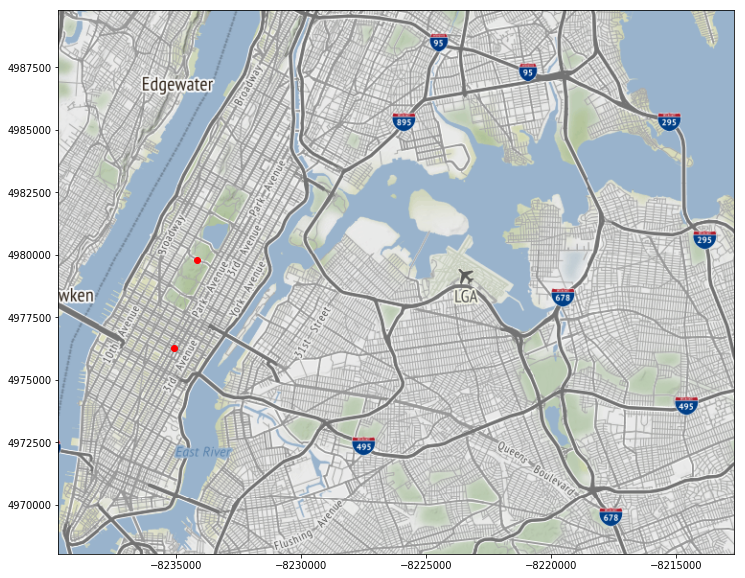

In [21]:
df = pd.DataFrame({
    'LAT'  :[avg_pickup_latitude, nyc_station_latitude],
    'LONG' :[avg_pickup_longitude, nyc_station_longitude]
})

# Convert DataFrame to GeoDataFrame  
coords = pd.Series(zip(df["LONG"], df["LAT"]))
geo_df = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry = coords.apply(Point)).to_crs(epsg=3857)

# ... and make the plot
ax = geo_df.plot(figsize=(15, 10), alpha=1, color="red")
ax.set(ylim=(geo_min_y, geo_max_y), xlim=(geo_min_x, geo_max_x))

# Add basemap below
add_basemap(ax, 12)

# 3. Holidays

In [22]:
holidays = spark.read.parquet(structured_basedir + "/holidays")
holidays.limit(10).toPandas()

id        date                            description  bank_holiday
0   1  2012-01-02                           New Year Day          True
1   2  2012-01-16             Martin Luther King Jr. Day          True
2   3  2012-02-20  Presidents Day (Washingtons Birthday)          True
3   4  2012-05-28                           Memorial Day          True
4   5  2012-07-04                       Independence Day          True
5   6  2012-09-03                              Labor Day          True
6   7  2012-10-08                           Columbus Day          True
7   8  2012-11-12                           Veterans Day          True
8   9  2012-11-22                       Thanksgiving Day          True
9  10  2012-12-25                          Christmas Day          True

In [23]:
holidays.printSchema()

root
 |-- id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- description: string (nullable = true)
 |-- bank_holiday: boolean (nullable = true)



# 4. Join Data

In [19]:
nyc_daily_weather = daily_weather.filter((daily_weather["usaf"] == nyc_station_usaf) & (daily_weather["wban"] == nyc_station_wban)).cache()
nyc_hourly_weather = hourly_weather.filter((hourly_weather["usaf"] == nyc_station_usaf) & (hourly_weather["wban"] == nyc_station_wban)).cache()

In [24]:
all_data = taxi_aggregates \
    .join(f.broadcast(holidays), ["date"], how="leftOuter") \
    .drop(holidays["date"]) \
    .drop(holidays["id"]) \
    .withColumnRenamed("description", "holiday_description") \
    .join(f.broadcast(nyc_hourly_weather), ["date", "hour"], how="leftOuter") \
    .withColumnRenamed("precipitation", "hourly_precipitation") \
    .withColumnRenamed("wind_speed", "hourly_wind_speed") \
    .withColumnRenamed("temperature", "hourly_temperature") \
    .withColumnRenamed("temperature", "daily_temperature") \
    .drop(nyc_hourly_weather["date"])\
    .drop(nyc_hourly_weather["hour"]) \
    .drop(nyc_hourly_weather["usaf"])\
    .drop(nyc_hourly_weather["wban"])\
    .join(f.broadcast(nyc_daily_weather), ["date"], how="leftOuter") \
    .withColumnRenamed("precipitation", "daily_precipitation") \
    .withColumnRenamed("wind_speed", "daily_wind_speed") \
    .drop(nyc_daily_weather["date"])\
    .drop(nyc_daily_weather["usaf"])\
    .drop(nyc_daily_weather["wban"])\
    .orderBy("date", "hour") \
    .cache()

all_data.limit(10).toPandas()

date  hour  lat_idx  long_idx  trip_count  passenger_count  \
0  2013-01-01     0       44        10          67              118   
1  2013-01-01     0       42        13         101              210   
2  2013-01-01     0       28         3          18               28   
3  2013-01-01     0       65        18          14               21   
4  2013-01-01     0       12         6          14               29   
5  2013-01-01     0       49         1          17               32   
6  2013-01-01     0       34        14           1                1   
7  2013-01-01     0       99        17          17               35   
8  2013-01-01     0       54        57           2                3   
9  2013-01-01     0       14         0          10               20   

   fare_amount  tip_amount  total_amount holiday_description  bank_holiday  \
0        788.0       55.50        920.10        New Year Day          True   
1        989.0       71.59       1171.19        New Year Day          True   
2        217.0        9.65        244.65        New Year Day          True   
3        186.5       18.60        226.35        New Year Day          True   
4        181.0       17.65        221.90        New Year Day          True   
5        162.0       15.70        194.70        New Year Day          True   
6          5.0        1.50          7.50        New Year Day          True   
7        198.5       13.45        229.45        New Year Day          True   
8         15.0        0.00         17.00        New Year Day          True   
9        115.0        5.60        130.60        New Year Day          True   

   hourly_wind_speed  hourly_temperature  hourly_precipitation  temperature  \
0                4.1                 2.8                   0.0     3.241667   
1                4.1                 2.8                   0.0     3.241667   
2                4.1                 2.8                   0.0     3.241667   
3                4.1                 2.8                   0.0     3.241667   
4                4.1                 2.8                   0.0     3.241667   
5                4.1                 2.8                   0.0     3.241667   
6                4.1                 2.8                   0.0     3.241667   
7                4.1                 2.8                   0.0     3.241667   
8                4.1                 2.8                   0.0     3.241667   
9                4.1                 2.8                   0.0     3.241667   

   daily_wind_speed  daily_precipitation  
0          3.156522                  0.0  
1          3.156522                  0.0  
2          3.156522                  0.0  
3          3.156522                  0.0  
4          3.156522                  0.0  
5          3.156522                  0.0  
6          3.156522                  0.0  
7          3.156522                  0.0  
8          3.156522                  0.0  
9          3.156522                  0.0

In [25]:
all_data.write.parquet(integrated_basedir + "/taxi-trips-hourly")